In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/brain-mri-detection-and-segmentation/utilities.py
/kaggle/input/brain-mri-detection-and-segmentation/data_mask.csv
/kaggle/input/brain-mri-detection-and-segmentation/data.csv
/kaggle/input/brain-mri-detection-and-segmentation/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/brain-mri-detection-and-segmentation/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/brain-mri-detection-and-segmentation/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/brain-mri-detection-and-segmentation/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/brain-mri-detection-and-segmentation/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/brain-mri-detection-and-segmentation/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/brain-mri-detection-and-segmentation/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/brain-mri-detection-and-segmentation/TCGA_DU_7010_19860307/TCGA_DU_7010_198603

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import os 
from skimage import io
from PIL import Image
from tensorflow.keras import backend as K
  
#creating a custom datagenerator:

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = '/kaggle/input/brain-mri-detection-and-segmentation/', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = '/kaggle/input/brain-mri-detection-and-segmentation/' + str(list_ids[i])
      
      #mask path
      mask_path = '/kaggle/input/brain-mri-detection-and-segmentation/' + str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y






def prediction(test, model, model_seg):
  '''
  Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
  Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
  is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
  segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
  '''

  #directory
  directory = "/kaggle/input/brain-mri-detection-and-segmentation/"

  #Creating empty list to store the results
  mask = []
  image_id = []
  has_mask = []

  #iterating through each image in the test data
  for i in test.image_path:

    path = directory + str(i)

    #reading the image
    img = io.imread(path)

    #Normalizing the image
    img = img * 1./255.

    #Reshaping the image
    img = cv2.resize(img,(256,256))

    #Converting the image into array
    img = np.array(img, dtype = np.float64)
    
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction on the image
    is_defect = model.predict(img)

    #if tumour is not present we append the details of the image to the list
    if np.argmax(is_defect) == 0:
      image_id.append(i)
      has_mask.append(0)
      mask.append('No mask')
      continue

    #Read the image
    img = io.imread(path)

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 3))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no tumour
    if predict.round().astype(int).sum() == 0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask')
    else:
    #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)


  return image_id, mask, has_mask
        




'''
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}
'''
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


In [2]:
dfmask = pd.read_csv('/kaggle/input/brain-mri-detection-and-segmentation/data_mask.csv')
dfmask.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [3]:
dfmask.dtypes

patient_id    object
image_path    object
mask_path     object
mask           int64
dtype: object

0    2556
1    1373
Name: mask, dtype: int64


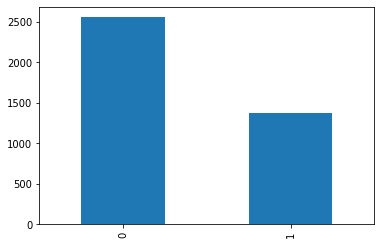

In [4]:
print(dfmask['mask'].value_counts())
dfmask['mask'].value_counts().plot(kind='bar')
plt.show()

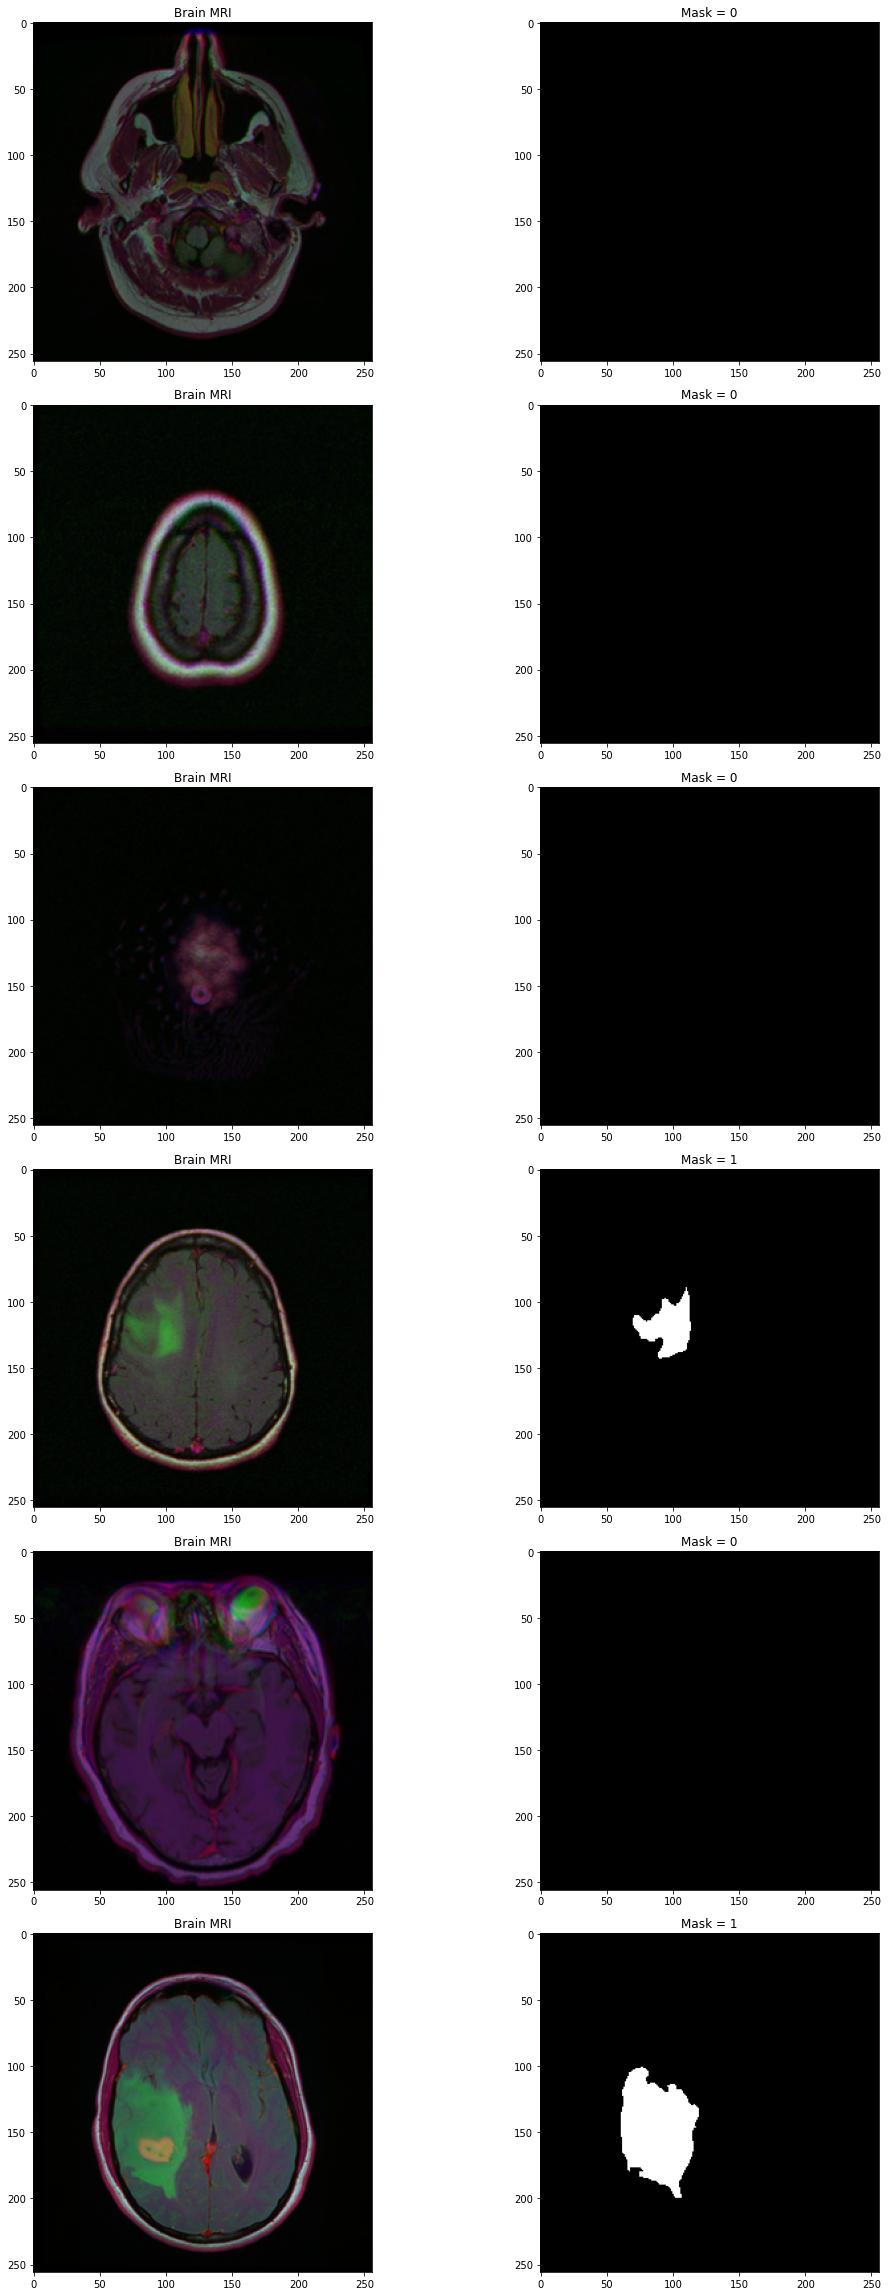

In [5]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
    i = random.randint(0, len(dfmask))
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(cv2.imread('/kaggle/input/brain-mri-detection-and-segmentation/'+dfmask.image_path[i]))
    axs[count][1].title.set_text("Mask = " + str(dfmask['mask'][i]))
    axs[count][1].imshow(cv2.imread('/kaggle/input/brain-mri-detection-and-segmentation/'+dfmask.mask_path[i]))
    count += 1

fig.tight_layout()

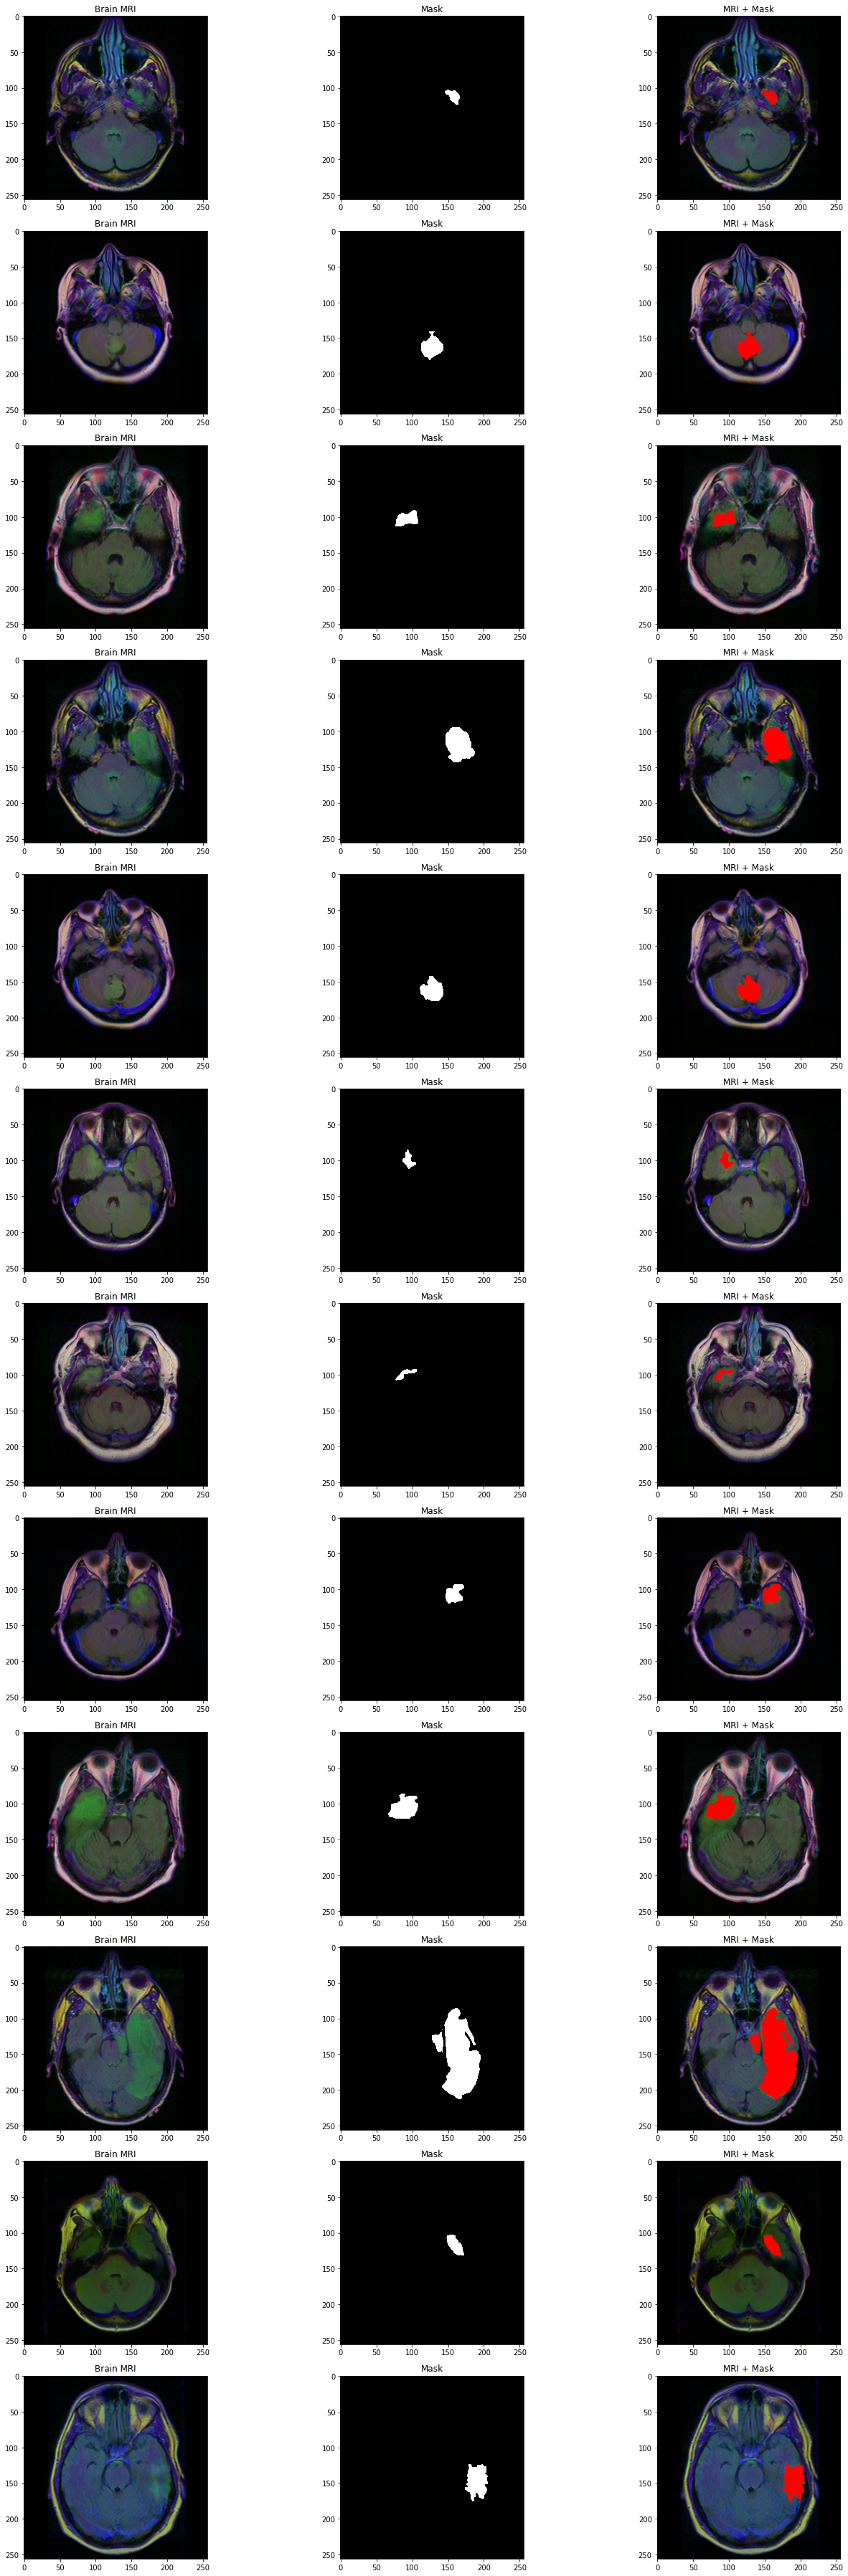

In [6]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(dfmask)):
    if dfmask['mask'][i] ==1 and count <12:
        img = io.imread('/kaggle/input/brain-mri-detection-and-segmentation/'+dfmask.image_path[i])
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread('/kaggle/input/brain-mri-detection-and-segmentation/'+dfmask.mask_path[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask, cmap = 'gray')

    
        img[mask == 255] = (255, 0, 0)
        axs[count][2].title.set_text('MRI + Mask')
        axs[count][2].imshow(img)
        count+=1

fig.tight_layout()

# Creating the classification

In [7]:
traindf = dfmask.drop('patient_id',axis=1)
traindf['mask'] = traindf['mask'].apply(lambda x: str(x))
traindf.shape

(3929, 3)

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(traindf, test_size = 0.15)
train.shape,test.shape

((3339, 3), (590, 3))

In [9]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [10]:
train_generator=datagen.flow_from_dataframe(dataframe=train,directory= '/kaggle/input/brain-mri-detection-and-segmentation/',
                                            x_col='image_path',y_col='mask',subset="training",batch_size=16,shuffle=True,
                                            class_mode="categorical",target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(dataframe=train,directory= '/kaggle/input/brain-mri-detection-and-segmentation/',
                                            x_col='image_path',y_col='mask',subset="validation",batch_size=16,shuffle=True,
                                            class_mode="categorical",target_size=(256,256))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(dataframe=test,directory= '/kaggle/input/brain-mri-detection-and-segmentation/',
                                                x_col='image_path',y_col='mask',batch_size=16,shuffle=False,
                                                class_mode='categorical',target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [11]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))
basemodel.summary()

2022-02-15 17:01:51.203586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 17:01:51.334694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 17:01:51.335615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 17:01:51.336929: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [12]:
for layer in basemodel.layers:
    layers.trainable = False

In [13]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [15]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

2022-02-15 17:02:23.053344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-02-15 17:02:30.206362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


177/177 [==============================] - 41s 156ms/step - loss: 0.8418 - accuracy: 0.7411 - val_loss: 2.9274 - val_accuracy: 0.6472

Epoch 00001: val_loss improved from inf to 2.92740, saving model to classifier-resnet-weights.hdf5
Epoch 2/40
177/177 [==============================] - 24s 138ms/step - loss: 0.4340 - accuracy: 0.8296 - val_loss: 2.0411 - val_accuracy: 0.6512

Epoch 00002: val_loss improved from 2.92740 to 2.04110, saving model to classifier-resnet-weights.hdf5
Epoch 3/40
177/177 [==============================] - 24s 137ms/step - loss: 0.3286 - accuracy: 0.8898 - val_loss: 0.6660 - val_accuracy: 0.6492

Epoch 00003: val_loss improved from 2.04110 to 0.66599, saving model to classifier-resnet-weights.hdf5
Epoch 4/40
177/177 [==============================] - 24s 136ms/step - loss: 0.2598 - accuracy: 0.8998 - val_loss: 1.1925 - val_accuracy: 0.6512

Epoch 00004: val_loss did not improve from 0.66599
Epoch 5/40
177/177 [==============================] - 24s 136ms/step - 

In [16]:
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
    json_file.write(model_json)

In [17]:
with open('classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('classifier-resnet-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [18]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)
test_predict.shape

36/36 [==============================] - 4s 98ms/step


(576, 2)

In [19]:
predict = []

for i in test_predict:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [20]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

Accuracy: 0.9461805555555556

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       391
           1       0.94      0.89      0.91       185

   micro avg       0.95      0.95      0.95       576
   macro avg       0.94      0.93      0.94       576
weighted avg       0.95      0.95      0.95       576



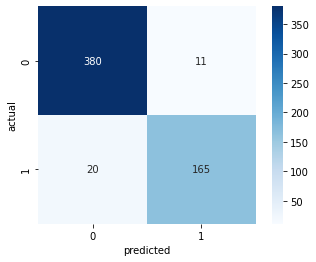

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

accuracy = accuracy_score(original, predict)
print(f'Accuracy: {accuracy}\n')
print(classification_report(original,predict, labels = [0,1]))
matrix = confusion_matrix(original, predict)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

# Segmentation

In [22]:
dftum = dfmask[dfmask['mask'] == 1]
dftum.shape

(1373, 4)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(dftum, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [27]:
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [28]:
def resblock(X, f):
    X_copy = X
    X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [29]:
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [30]:
input_shape = (256,256,3)

X_input = Input(input_shape)

conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

conv5_in = resblock(pool_4, 256)

up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [31]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

In [42]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="/kaggle/working/segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [43]:
os.chdir('/kaggle/input/brain-mri-detection-and-segmentation/')

In [44]:
history = model_seg.fit(training_generator , epochs = 50, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/50
72/72 [==============================] - 12s 129ms/step - loss: 0.4096 - tversky: 0.6940 - val_loss: 0.5849 - val_tversky: 0.5102

Epoch 00001: val_loss improved from inf to 0.58490, saving model to /kaggle/working/segmentation-weights.hdf5
Epoch 2/50
72/72 [==============================] - 8s 115ms/step - loss: 0.3446 - tversky: 0.7566 - val_loss: 0.4359 - val_tversky: 0.6657

Epoch 00002: val_loss improved from 0.58490 to 0.43591, saving model to /kaggle/working/segmentation-weights.hdf5
Epoch 3/50
72/72 [==============================] - 8s 113ms/step - loss: 0.3232 - tversky: 0.7763 - val_loss: 0.4274 - val_tversky: 0.6714

Epoch 00003: val_loss improved from 0.43591 to 0.42744, saving model to /kaggle/working/segmentation-weights.hdf5
Epoch 4/50
72/72 [==============================] - 9s 123ms/step - loss: 0.2996 - tversky: 0.7978 - val_loss: 0.4516 - val_tversky: 0.6525

Epoch 00004: val_loss did not improve from 0.42744
Epoch 5/50
72/72 [============================

In [46]:
model_json = model_seg.to_json()
with open("/kaggle/working/ResUNet-model.json","w") as json_file:
    json_file.write(model_json)

In [49]:
with open('/kaggle/working/ResUNet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# cargar la arquitectura del modelo
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('/kaggle/working/segmentation-weights.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [50]:
image_id, mask, has_mask = prediction(test, model, model_seg)

In [55]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_40...   
1    TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_59...   
2    TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_25...   
3    TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_4.tif   
4    TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52...   
..                                                 ...   
585  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_10...   
586  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_13...   
587  TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_14...   
588  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_46...   
589  TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_8.tif   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1                                              No mask         0  
2                                              No mask         0  
3                                              No mask         0  
4                                              No mask         0  
..                                                 ...       ...  
585                                            No mask         0  
586  [[[[8.6600164e-07], [5.429585e-07], [4.2730122...         1  
587  [[[[8.8975264e-07], [4.7185927e-07], [2.564762...         1  
588  [[[[3.8300766e-07], [1.04063915e-07], [1.75584...         1  
589                                            No mask         0  

[590 rows x 3 columns]

In [56]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_40...   
1  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_59...   
2  TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_25...   
3  TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_4.tif   
4  TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52...   

                                           mask_path mask predicted_mask  \
0  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_40...    0        No mask   
1  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_59...    0        No mask   
2  TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_25...    0        No mask   
3  TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_4_...    0        No mask   
4  TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52...    0        No mask   

   has_mask  
0         0  
1         0  
2         0  
3         0  
4         0

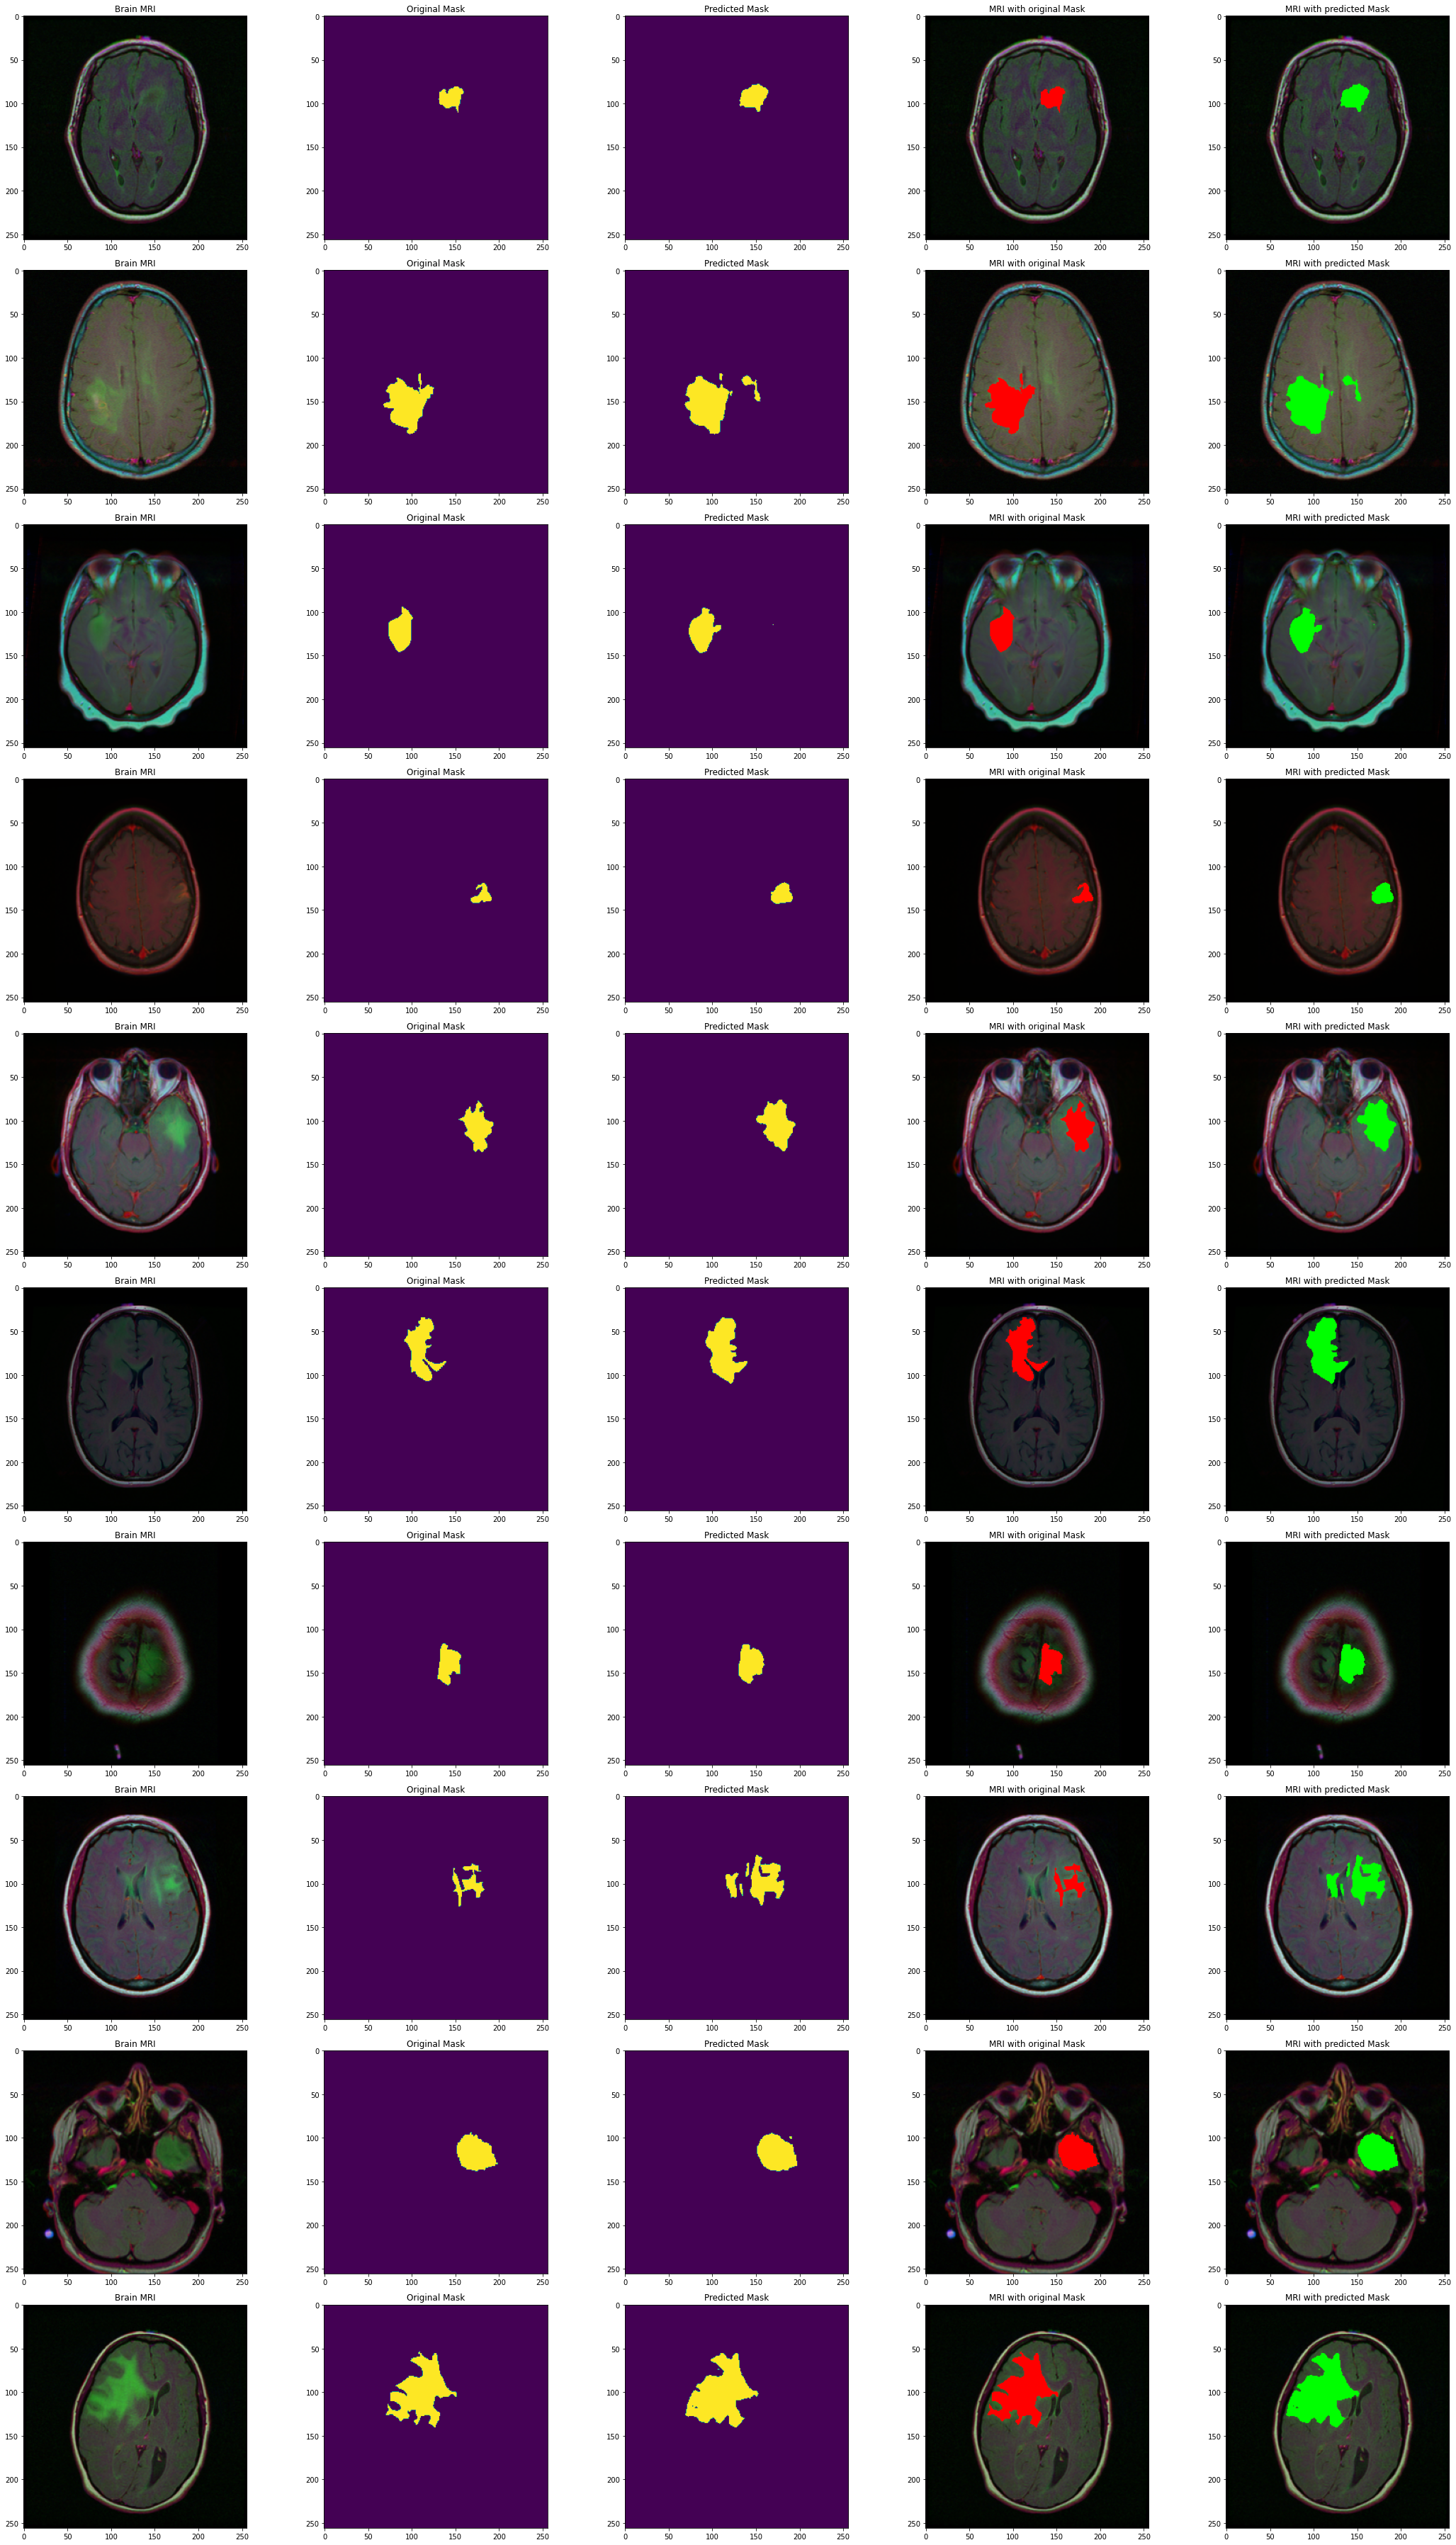

In [58]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with original Mask")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()